# Music Generation using RNN

#### Importing libraries

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

### Loading data

In [ ]:
songs = mdl.lab1.load_training_data()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Information about Data
#### So we have 817 songs in our data

In [4]:
print(songs[0])

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


#### This is how a song looks like in an ABC Notation

In [ ]:
# Lets listen to this song
mdl.lab1.play_song(songs[0])

In [6]:
#Now join all songs in a single list
songs_joined = "\n\n".join(songs)

In [7]:
#length of our data
len(songs_joined)

200679

In [8]:
# unique character of our data (vocab)

vocab = sorted(set(songs_joined))

In [9]:
# length of our vocab ( total unique characters of our vocab)
len(vocab)

83

#### Vectorizing the text

In [10]:
abc2vec = {u:i for i,u in enumerate(vocab)}

In [11]:
vec2abc = np.array(vocab)

In [ ]:
#printing
print(abc2vec)
print(vec2abc)

In [13]:
## vectarizing the whole song string

def vectorize_string(string):
  vectorized_string = np.array([abc2vec[i] for i in string])
  return vectorized_string

In [14]:
vectorized_songs = vectorize_string(songs_joined)

In [15]:
vectorized_songs[:5]

array([49, 22, 13,  0, 45])

In [16]:
n = vectorized_songs.shape[0] - 1
n

200678

# Creating input and target string

In [17]:
def get_batch(vect_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1

  idx = np.random.choice(n-seq_length, batch_size)
  input_batch = [vect_songs[i:i+seq_length] for i in idx]
  output_batch = [vect_songs[i+1:i+1+seq_length] for i in idx]
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


In [18]:
input , target  = get_batch(vectorized_songs, 2 , 1)

In [19]:
input

array([[82, 28]])

In [20]:
target

array([[28, 30]])

# The RNN Model

In [21]:
# defining LSTM

In [22]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [23]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    LSTM(rnn_units),
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [24]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


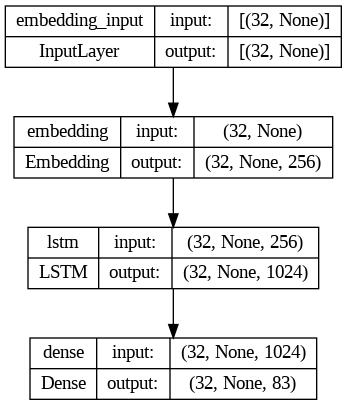

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [27]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

In [28]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 3000
batch_size = 10
seq_length = 150
learning_rate = 5e-3

# Model parameters:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

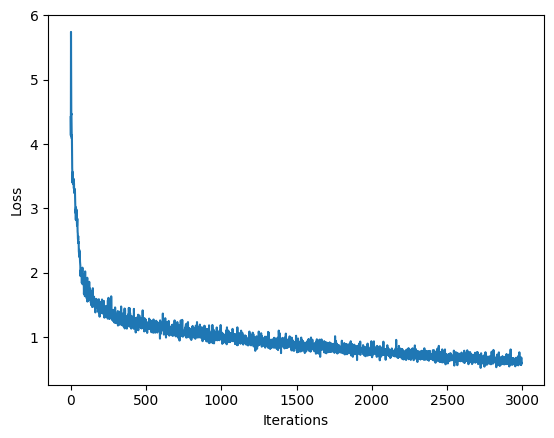

100%|██████████| 3000/3000 [02:44<00:00, 18.27it/s]


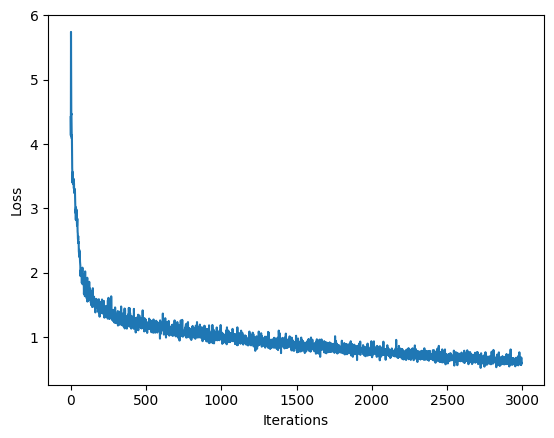

In [29]:
### Define optimizer and training operation ###

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

# Begin training!#

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm(range(num_training_iterations)):

  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  history.append(loss.numpy().mean())
  plotter.plot(history)

  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

model.save_weights(checkpoint_prefix)

In [30]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

In [31]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [32]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  input_eval = [abc2vec[s] for s in start_string] # TODO
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(vec2abc[predicted_id])



  return (start_string + ''.join(text_generated))

In [39]:
generated_text = generate_text(model, start_string="X", generation_length=2000)

100%|██████████| 2000/2000 [00:18<00:00, 105.86it/s]


In [ ]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  waveform = mdl.lab1.play_song(song)

  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)